# AI for Earth System Science Hackathon 2020
# HOLODEC Machine Learning Challenge Problem
Matt Hayman, Aaron Bansemer, David John Gagne, Gabrielle Gantos, Gunther Wallach, Natasha Flyer

## Introduction
<center><img src='https://raw.githubusercontent.com/NCAR/ai4ess-hackathon-2020/master/notebooks/holodec_images/image2.png'><center>

The properties of the water and ice particles in clouds are critical to many aspects of weather and climate.  The size, shape, and concentration of ice particles control the radiative properties of cirrus clouds.  The spatial distribution of water droplets in warm clouds may influence the formation of drizzle and rain.  The interactions among droplets, ice particles, and aerosols impact precipitation, lightning, atmospheric chemistry, and more.  Measurements of natural cloud particles are often taken aboard research aircraft with instruments mounted on the wings.  One of the newer technologies used for these instruments is inline holographic imaging, which has the important advantage of being able to instantaneously record all of the particles inside a small volume of air.  Using this technology, the Holographic Detector for Clouds (HOLODEC) has been developed by the university community and NCAR to improve our cloud measurement capabilities.

A hologram captures electro-magnatic field amplitude and phase (or wavefront) incident on a detector.  In contrast, standard imaging captures only the amplitude of the electric field.  Unlike a standard image, holograms can be computationally refocused on any object within the capture volume using standard wave propagation calculations. The figure below shows an example of an inline hologram (large image) with five out of focus particles.  The five smaller images show the reconstruction from each particle by computationally propagating the electro-magnetic field back to the depth position of each particle. 

<center><img src='https://raw.githubusercontent.com/NCAR/ai4ess-hackathon-2020/master/notebooks/holodec_images/image5.png'><center>

HOLODEC is an airborne holographic cloud imager capable of capturing particle size distributions in a single shot, so a measured particle size distribution is localized to a specific part of the cloud (not accumulated over a long path length).  By capturing a hologram, each particle can be imaged irrespective of its location in the sample volume, and its size and position can be accurately captured.

While holographic imaging provides unparalleled information about cloud particles, processing the raw holograms is also computationally expensive.  Lacking prior knowledge of the particle position in depth, a typical HOLODEC hologram is reconstructed at 1000 planes (or depths) using standard diffraction calculations.  At each plane, a particle’s image sharpness is evaluated and the particle size and position is determined only at a plane where it is in focus.  In addition to the computational cost, the processing requires human intervention to recognize when a “particle” is really just artifacts of interfering scattered fields.

The objective of this project is to develop a machine learning solution to process HOLODEC data that is more computationally efficient than the first-principles based processor.  

An important factor in processing hologram data is that the scattered field from a particle spreads out as it propagates.  The image below shows the scattered field from a 50 µm particle at distances in increments of 0.1 mm from the particle (0 to 0.7 mm).  As the scattered field expands, it’s power is also distributed over a larger area.

![holodec 3d](https://raw.githubusercontent.com/NCAR/ai4ess-hackathon-2020/master/notebooks/holodec_images/image1.png)

For simplicity, this project deals with simulated holographic data where particle shapes are limited to spheres.  Two datasets are provided.  The first dataset contains only one particle per hologram.  If you are successful in processing the first dataset, or you wish to immediately focus on a more challenging case, you can work on the second dataset that contains three particles per hologram.


## Software Requirements
This notebook requires Python >= 3.7. The following libraries are required:
* numpy
* scipy
* matplotlib
* xarray
* pandas
* scikit-learn
* tensorflow >= 2.1
* netcdf4
* h5netcdf
* tqdm
* s3fs
* zarr

In [ ]:
!pip install numpy scipy matplotlib xarray pandas scikit-learn tensorflow netcdf4 h5netcdf tqdm s3fs zarr

In [ ]:
# if working on google colab
! pip install -U -q PyDrive
from google.colab import drive
drive.mount('/content/gdrive')

## Data
The datasets consist of synthetically-generated holograms of cloud droplets.  Each dataset is in zarr format, and contains a series of hologram images as well as the properties of each particle in the image.  The zarr variable names and properties are as follows:

| Variable Name | Description | Dimensions | Units/Range|
| ------------- | :----:|:----------- |:------|
| image  | Stack of single-color images. Each image is 600x400 pixels, ranging from 0-255 in intensity. | nHolograms, 600, 400 | 0 to 255 (grayscale image) |
| x  |  X-position of each particle in the dataset.  The origin is at the center of the hologram image. | nParticles (can vary) | -888 to 888 micrometers |
| y  | Y-position of each particle in the dataset.  The origin is at the center of the hologram image. |  nParticles (can vary) | -592 to 592 micrometers |
| z  | Z-position of each particle in the dataset.  The origin is at the focal plane of the instrument (all particles are unfocused). | nParticles (can vary) | 14000 to 158000 micrometers |
| d  | Diameter of each simulated droplet | nParticles (can vary) | 20 to 70 micrometers |
| hid | Hologram ID specifies which hologram this particle is contained in.  For example, if hid=1, the corresponding x, y, z, and d variables are found in the first hologram. | nParticles (can vary) | 1 to nHolograms |
| Dx (global attribute) | Resolution of each pixel, == 2.96 micrometers.  Use if you wish to convert x/y position to pixel number |  |  |

There are two datasets for this project, a single-particle dataset and a three-particle dataset.  The single-particle dataset only contains one particle per hologram (nHolograms = nParticles). There are 50,000 holograms in the training dataset that correspond to 50,000 particles.

The three-particle dataset contains three particles per hologram.  This dataset also contains 50,000 holograms but 150,000 particles.  Be sure to use the hid variable to figure out which hologram a particle is contained in.

The ultimate goal of this project is to be able to find particles in the holograms and determine their x, y, z, and d values. This process is straightforward for finding a single particle, but finding multiple particles and their properties is much more challenging. A simpler objective that could also assist in speeding up the HOLODEC processing is calculating the relative distribution of particle mass in the z-direction from the holograms, which is a combination of information from z and d. 

<center><img src='https://raw.githubusercontent.com/NCAR/ai4ess-hackathon-2020/master/notebooks/holodec_images/image4.png'><center>


### Potential Input Variables
| Variable Name | Units | Description | Relevance |
| ------------- | :----:|:----------- | :--------:|
| hologram   |  arbitrary |  8 bit (0-255) amplitude captured by CCD  | standard input data for processing  |


### Output Variables
| Variable Name | Units | Description |
| ------------- | :----:|:----------- |
| x  |  µm     |  particle horizontal position |
| y  |  µm     |  particle vertical position  |
| z  | µm  | particle position in depth (along the direction of propagation) |
| d  | µm  | particle diameter |
| hid | arbitrary | hologram ID by particle|


### Training Set

The single-particle training dataset is in the zarr format described above, with 15,000 holograms and 15,000 corresponding particles.

The three-particle training dataset contains 15,000 holograms and 45,000 particles.


### Validation Set
The single-particle validation dataset is in the zarr format described above, with 5,000 holograms and 5,000 corresponding particles.

The three-particle validation dataset contains 5,000 holograms and 15,000 particles.


### Test Set
The single-particle test dataset is in the zarr format described above, with 5,000 holograms and 5,000 corresponding particles.

The three-particle test dataset contains 5,000 holograms and 15,000 particles.


### Data Transforms

The input images only need to be normalized between 0 and 1 by dividing by 255. 


In [ ]:
# Module imports 
import argparse
import random
import os
from os.path import join, exists
import sys
import s3fs
import yaml
import zarr
import xarray as xr
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler
from sklearn.metrics import mean_absolute_error, max_error
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, MaxPool2D
from tensorflow.keras.models import Model, save_model
from tensorflow.keras.optimizers import Adam, SGD

seed = 328942
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
# Limit GPU memory usage
gpus = tf.config.get_visible_devices("GPU")
for device in gpus:
    print(device)
    tf.config.experimental.set_memory_growth(device, True)


PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [ ]:
# define some datset helper functions

num_particles_dict = {
    1 : '1particle',
    3 : '3particle',
    'multi': 'multiparticle'}

split_dict = {
    'train' : 'training',
    'test'   : 'test',
    'valid': 'validation'}

def dataset_name(num_particles, split, file_extension='zarr'):
    """
    Return the dataset filename given user inputs
    
    Args: 
        num_particles: (int or str) Number of particles per hologram (1, 3, or 'multi')
        split: (str) Dataset split of either 'train', 'valid', or 'test'
        file_extension: (str) Dataset file extension
    
    Returns:
        dataset: (str) Dataset name
    """
    
    valid = [1,3,'multi']
    if num_particles not in valid:
        raise ValueError("results: num_particles must be one of %r." % valid)
    num_particles = num_particles_dict[num_particles]
    
    valid = ['train','test','valid']
    if split not in valid:
        raise ValueError("results: split must be one of %r." % valid)
    split = split_dict[split]
    
    return f'synthetic_holograms_{num_particles}_{split}_small.{file_extension}'

def open_zarr(path_data, num_particles, split):
    """
    Open a HOLODEC Zarr file hosted on AWS
    
    Args: 
        path_data: (str) Path to directory containing datset
        num_particles: (int or str) Number of particles per hologram (1, 3, or 'multi')
        split: (str) Dataset split of either 'train', 'valid', or 'test'
    
    Returns:
        dataset: (xarray Dataset) Opened dataset
    """
    path_data = os.path.join(path_data, dataset_name(num_particles, split))
    fs = s3fs.S3FileSystem(anon=True, default_fill_cache=False)
    store = s3fs.S3Map(root=path_data, s3=fs, check=False)
    dataset = xr.open_zarr(store=store)
    return dataset

def scale_images(images, scaler_vals=None):
    """
    Takes in array of images and scales pixel values between 0 and 1
    
    Args: 
        images: (np array) Array of images 
        scaler_vals: (dict) Image scaler 'max' and 'min' values
        
    Returns:
        images_scaled: (np array) Scaled array of images with pixel values between 0 and 1
        scaler_vals: (dict) Image scaler 'max' and 'min' values
    """
    
    if scaler_vals is None:
        scaler_vals = {}
        scaler_vals["min"] = images.min()
        scaler_vals["max"] = images.max()
    images_scaled = (images.astype(np.float32) - scaler_vals["min"]) / (scaler_vals["max"] - scaler_vals["min"])
    return images_scaled, scaler_vals

def load_scaled_datasets(path_data, num_particles, output_cols, slice_idx,
                         split='train', scaler_vals=None):
    """
    Given a path to training or validation datset, the number of particles per
    hologram, and output columns, returns scaled inputs and raw outputs.
    
    Args: 
        path_data: (str) Path to directory containing training and validation datsets
        num_particles: (int or str) Number of particles per hologram (1, 3, or 'multi') 
        output_cols: (list of strings) List of feature columns to be used
        
    Returns:
        inputs_scaled: (np array) Input data scaled between 0 and 1
        outputs: (df) Output data specified by output_cols
        scaler_vals: (dict) list of training/validation/test files
    """
    
    if split == 'valid':
      slice_idx = int(slice_idx/3)
    print("Slicing data into inputs/outputs")
    ds = open_zarr(path_data, num_particles, split)
    inputs = ds["image"].values[:slice_idx]
    outputs = ds[output_cols].to_dataframe().loc[:slice_idx-1,:]
    ds.close()
    print(f"\t- outputs.shape: {outputs.shape}")

    print("Scaling input data")
    if split == 'train':
      inputs_scaled, scaler_vals = scale_images(inputs)
    else:
      slice_idx = int(slice_idx/3)
      inputs_scaled, _ = scale_images(inputs, scaler_vals)
  
    inputs_scaled = np.expand_dims(inputs_scaled, -1)
    print(f"\t- inputs_scaled.shape: {inputs_scaled.shape}")

    return inputs_scaled, outputs, scaler_vals


In [ ]:
# data definitions

path_data = "ncar-aiml-data-commons/holodec/"
num_particles = 3
output_cols = ["hid", "x", "y", "z", "d"]
num_z_bins = 20
slice_idx = 6000


In [ ]:
# load and normalize data (this takes approximately 2 minutes)
train_inputs_scaled,\
train_outputs,\
scaler_vals = load_scaled_datasets(path_data,
                                   num_particles,
                                   output_cols,
                                   slice_idx)

valid_inputs_scaled,\
valid_outputs, _ = load_scaled_datasets(path_data,
                                        num_particles,
                                        output_cols,
                                        slice_idx,
                                        split='valid',
                                        scaler_vals=scaler_vals)

Slicing data into inputs/outputs
	- outputs.shape: (6000, 5)
Scaling input data
	- inputs_scaled.shape: (6000, 600, 400, 1)
Slicing data into inputs/outputs
	- outputs.shape: (2000, 5)
Scaling input data
	- inputs_scaled.shape: (2000, 600, 400, 1)


In [ ]:
# Plot a single hologram with the particles overlaid
def plot_hologram(h, outputs):
    """
    Given a hologram number, plot hologram and particle point
    
    Args: 
        h: (int) hologram number
    
    Returns:
        print of pseudocolor plot of hologram and hologram particles
    """    
    x_vals = np.linspace(-888, 888, train_inputs_scaled[h, :, :, 0].shape[0])
    y_vals = np.linspace(-592, 592, train_inputs_scaled[h, :, :, 0].shape[1])

    plt.figure(figsize=(12, 8))
    plt.pcolormesh(x_vals, y_vals, train_inputs_scaled[h, :, :, 0].T, cmap="RdBu_r")
    h_particles = np.where(outputs["hid"] == h + 1)[0]
    for h_particle in h_particles:
        plt.scatter(outputs.loc[h_particle, "x"],
                    outputs.loc[h_particle, "y"],
                    outputs.loc[h_particle, "d"] ** 2,
                    outputs.loc[h_particle, "z"],
                    vmin=outputs["z"].min(),
                    vmax=outputs["z"].max(),
                    cmap="cool")
        plt.annotate(f"d: {outputs.loc[h_particle,'d']:.1f} µm",
                     (outputs.loc[h_particle, "x"], outputs.loc[h_particle, "y"]))
    plt.xlabel("horizontal particle position (µm)", fontsize=16)
    plt.ylabel("vertical particle position (µm)", fontsize=16)
    plt.title("Hologram and particle positions plotted in four dimensions", fontsize=20, pad=20)
    plt.colorbar().set_label(label="z-axis particle position (µm)", size=16)


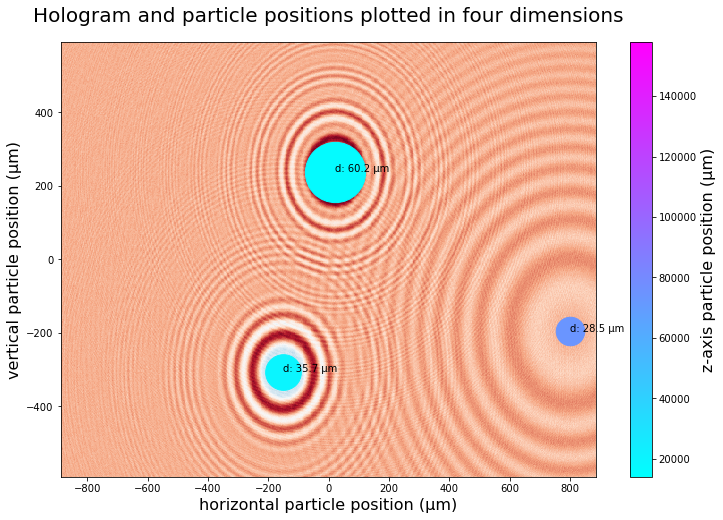

In [ ]:
h = 300
plot_hologram(h, train_outputs)

## Baseline Machine Learning Model
A baseline model for solving this problem uses a ConvNET architecture implemented in Keras.  The first three convolution layers consist of 5 x 5 pixel kernels with rectified linear unit (relu) activation followed by a 4 x 4 pixel max pool layer.  The first convolution layer has 8 channels, the second contains 16 channels, and the third contains 32 channels.  The output of the third convolution layer is flattened and fed into a dense layer with 64 neurons and relu activation.  Finally the output layer consists of the relative mass in 20 bins.  The model is trained using a mean absolute error and categorical cross-entropy loss function.

Training time: 20 epochs in ~2.5 minutes


In [ ]:
class Conv2DNeuralNetwork(object):
    """
    A Conv2D Neural Network Model that can support arbitrary numbers of layers.

    Attributes:
        filters: List of number of filters in each Conv2D layer
        kernel_sizes: List of kernel sizes in each Conv2D layer
        conv2d_activation: Type of activation function for conv2d layers
        pool_sizes: List of Max Pool sizes
        dense_sizes: Sizes of dense layers
        dense_activation: Type of activation function for dense layers
        output_activation: Type of activation function for output layer
        lr: Optimizer learning rate
        optimizer: Name of optimizer or optimizer object.
        adam_beta_1: Exponential decay rate for the first moment estimates
        adam_beta_2: Exponential decay rate for the first moment estimates
        sgd_momentum: Stochastic Gradient Descent momentum
        decay: Optimizer decay
        loss: Name of loss function or loss object
        batch_size: Number of examples per batch
        epochs: Number of epochs to train
        verbose: Level of detail to provide during training
        model: Keras Model object
    """
    def __init__(self, filters=(8,), kernel_sizes=(5,), conv2d_activation="relu",
                 pool_sizes=(4,), dense_sizes=(64,), dense_activation="relu", output_activation="softmax",
                 lr=0.001, optimizer="adam",  adam_beta_1=0.9, adam_beta_2=0.999,
                 sgd_momentum=0.9, decay=0, loss="mse", batch_size=32, epochs=2, verbose=0):
        self.filters = filters
        self.kernel_sizes = [tuple((v,v)) for v in kernel_sizes]
        self.conv2d_activation = conv2d_activation
        self.pool_sizes = [tuple((v,v)) for v in pool_sizes]
        self.dense_sizes = dense_sizes
        self.dense_activation = dense_activation
        self.output_activation = output_activation
        self.lr = lr
        self.optimizer = optimizer
        self.optimizer_obj = None
        self.adam_beta_1 = adam_beta_1
        self.adam_beta_2 = adam_beta_2
        self.sgd_momentum = sgd_momentum
        self.decay = decay
        self.loss = loss
        self.batch_size = batch_size
        self.epochs = epochs
        self.verbose = verbose
        self.model = None

    def build_neural_network(self, input_shape, output_shape):
        """Create Keras neural network model and compile it."""
        conv_input = Input(shape=(input_shape), name="input")
        nn_model = conv_input
        for h in range(len(self.filters)):
            nn_model = Conv2D(self.filters[h], self.kernel_sizes[h], padding="same",
                              activation=self.conv2d_activation, name=f"conv2D_{h:02d}")(nn_model)
            nn_model = MaxPool2D(self.pool_sizes[h], name=f"maxpool2D_{h:02d}")(nn_model)
        nn_model = Flatten()(nn_model)
        for h in range(len(self.dense_sizes)):
            nn_model = Dense(self.dense_sizes[h], activation=self.dense_activation, name=f"dense_{h:02d}")(nn_model)
        nn_model = Dense(output_shape, activation=self.output_activation, name=f"dense_output")(nn_model)
        self.model = Model(conv_input, nn_model)
        if self.optimizer == "adam":
            self.optimizer_obj = Adam(lr=self.lr, beta_1=self.adam_beta_1, beta_2=self.adam_beta_2, decay=self.decay)
        elif self.optimizer == "sgd":
            self.optimizer_obj = SGD(lr=self.lr, momentum=self.sgd_momentum, decay=self.decay)
        self.model.compile(optimizer=self.optimizer, loss=self.loss)
        self.model.summary()

    def fit(self, x, y, xv, yv):
        if len(y.shape) == 1:
            output_shape = 1
        else:
            output_shape = y.shape[1]
        input_shape = x.shape[1:]
        self.build_neural_network(input_shape, output_shape)
        self.model.fit(x, y, batch_size=self.batch_size, epochs=self.epochs,
                       verbose=self.verbose, validation_data=(xv, yv))
        return self.model.history.history

    def predict(self, x):
        y_out = self.model.predict(x, batch_size=self.batch_size)
        return y_out

    def predict_proba(self, x):
        y_prob = self.model.predict(x, batch_size=self.batch_size)
        return y_prob


### Z Relative Particle Mass Model
This neural network is tasked to predict the distribution of particle mass in the z-plane of the instrument. The relative mass is calculated by calculating the volume of each sphere based on the area and dividing by the total mass of all particles. The advantage of this target is that it behaves like a probability density function and sums to 1, and it is agnostic to the number of particles in the image.


In [ ]:
def calc_z_relative_mass(outputs, holograms, num_z_bins=20, z_bins=None):
    """
    Calculate z-relative mass from particle data.
    
    Args: 
        outputs: (np array) Output data previously specified by output_cols 
        holograms: (int) Number of holograms
        num_z_bins: (int) Number of bins for z_bins linspace
        z_bins: (np array) Bin linspace along the z-axis
    
    Returns:
        z_mass: (np array) Particle mass distribution by hologram
        z_bins: (np array) Bin linspace along the z-axis
    """
    
    if z_bins is None:
        z_bins = np.linspace(outputs["z"].min()- 100, outputs["z"].max() + 100, num_z_bins)
        print(z_bins)
    else:
        num_z_bins = z_bins.size
    z_mass = np.zeros((holograms, num_z_bins), dtype=np.float32)
    for i in range(outputs.shape[0]):
        z_pos = np.searchsorted(z_bins, outputs.loc[i, "z"], side="right") - 1
#         print(i, outputs.loc[i, "z"], z_pos)
        mass = 4 / 3 * np.pi * (outputs.loc[i, "d"])**3
#         print("\t", mass, int(outputs.loc[i, "hid"]) - 1)
        z_mass[int(outputs.loc[i, "hid"]) - 1, z_pos] += mass
    z_mass /= np.expand_dims(z_mass.sum(axis=1), -1)
    print(f"z_mass.shape: {z_mass.shape}\nz_bins.shape: {z_bins.shape}")
    return z_mass, z_bins


In [ ]:
z_bins = np.linspace(np.minimum(train_outputs["z"].min(), valid_outputs["z"].min()),
                     np.maximum(train_outputs["z"].max(), valid_outputs["z"].max()),
                     num_z_bins)

train_z_mass, _ = calc_z_relative_mass(train_outputs, len(train_outputs["hid"].unique()), z_bins=z_bins)
valid_z_mass, _ = calc_z_relative_mass(valid_outputs, len(valid_outputs["hid"].unique()), z_bins=z_bins)
train_inputs_scaled = train_inputs_scaled[0::3]
valid_inputs_scaled = train_inputs_scaled[0::3]

z_mass.shape: (2000, 20)
z_bins.shape: (20,)
z_mass.shape: (667, 20)
z_bins.shape: (20,)


### Three particle, z-mass model definition

In [ ]:
# conv2d_network definitions for 3 particle z mass solution

IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    path_out = "/content/gdrive/My Drive/micro_models/3particle_base"
else:
    path_out = "./holodec_models/3particle_base/"
if not exists(path_out):
    os.makedirs(path_out)
model_name = "cnn"
filters = [16, 24, 32]
kernel_sizes = [5, 5, 5]
conv2d_activation = "relu"
pool_sizes = [4, 4, 4]
dense_sizes = [64, 32]
dense_activation = "elu"
lr = 0.0003
decay = 0.1
optimizer = "adam"
loss = "categorical_crossentropy"
batch_size = 128
epochs = 40
verbose = 1

seed = 328942
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)


In [ ]:
# 3 particle z mass model build, compile, fit, and predict

three_start = datetime.now()
with tf.device('/device:GPU:0'):
    mod = Conv2DNeuralNetwork(filters=filters, kernel_sizes=kernel_sizes,
                              conv2d_activation=conv2d_activation,
                              pool_sizes=pool_sizes, dense_sizes=dense_sizes,
                              dense_activation=dense_activation, lr=lr,
                              optimizer=optimizer, decay=decay, loss=loss,
                              batch_size=batch_size, epochs=epochs, verbose=verbose)
    hist = mod.fit(train_inputs_scaled, train_z_mass, valid_inputs_scaled, valid_z_mass)
    
    train_z_mass_pred = mod.predict(train_inputs_scaled)
    valid_z_mass_pred = mod.predict(valid_inputs_scaled)
print(f"Running model took {datetime.now() - three_start} time")


In [ ]:
# visualize loss history

plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

In [ ]:
# save the model
print("Saving the model")
mod.model.save(join(path_out, model_name +".h5"))

In [ ]:
# clear your tf session without needing to re-load and re-scale data

del mod
tf.keras.backend.clear_session()


### Three Particle Metrics

How well do individual predictions (red) match with the actual particle locations (blue)?


In [ ]:
valid_index = 11
bin_size = z_bins[1] - z_bins[0]
plt.figure(figsize=(10, 6))
plt.bar(z_bins / 1000, valid_z_mass_pred[valid_index], bin_size / 1000, color='red', label="Predicted")
plt.bar(z_bins / 1000, valid_z_mass[valid_index], bin_size / 1000, edgecolor='blue', facecolor="none", lw=3, label="True")
plt.ylim(0, 1)
plt.xlabel("z-axis particle position (mm)", fontsize=16)
plt.ylabel("relative mass", fontsize=16)
plt.legend(loc="best")

If the model was completely unbiased, then mean relative mass in each bin should be nearly the same across all validation examples. In this case we see that the CNN preferentially predicts that the mass is closer to the camera, likely due to a combination of particles closer to the camera blocking those farther away along with more distant particles influencing the entire image. Since the CNN assumes image properties are more localized, it will struggle to detect the particles that are farther away.

In [ ]:
plt.bar(z_bins / 1000, valid_z_mass_pred.mean(axis=0), (z_bins[1] - z_bins[0]) / 1000, color='red')
plt.bar(z_bins / 1000, valid_z_mass.mean(axis=0), (z_bins[1]-z_bins[0]) / 1000, edgecolor='blue', facecolor="none", lw=3)
plt.xlabel("z location (mm)", fontsize=16)
plt.ylabel("Mean Relative Mass", fontsize=16)

In [ ]:
def ranked_probability_score(y_true, y_pred):
    return np.mean((np.cumsum(y_true, axis=1) - np.cumsum(y_pred, axis=1)) ** 2) / (y_true.shape[1] -1)

In [ ]:
rps_nn = ranked_probability_score(valid_z_mass, valid_z_mass_pred)
rps_climo = ranked_probability_score(valid_z_mass, np.ones(valid_z_mass_pred.shape) / valid_z_mass_pred.shape[1])
print(rps_nn, rps_climo)
rpss = 1 - rps_nn / rps_climo
print(f"RPSS: {rpss:0.3f}")

### One Particle Model
An easier problem is predicting the location and properties of synthetic single particles.


In [ ]:
# data definitions

path_data = "ncar-aiml-data-commons/holodec/"
num_particles = 1
output_cols_one  = ["x", "y", "z", "d"]
scaler_one = MinMaxScaler()
slice_idx = 6000


In [ ]:
# load and normalize data (this takes approximately 2 minutes)
train_inputs_scaled_one,\
train_outputs_one,\
scaler_vals_one = load_scaled_datasets(path_data,
                                   num_particles,
                                   output_cols,
                                   slice_idx)

valid_inputs_scaled_one,\
valid_outputs_one, _ = load_scaled_datasets(path_data,
                                        num_particles,
                                        output_cols,
                                        slice_idx,
                                        split='valid',
                                        scaler_vals=scaler_vals)

# extra transform step for output_cols_one in lieu of z mass

train_outputs_scaled_one = scaler_one.fit_transform(train_outputs_one[output_cols_one])
valid_outputs_scaled_one = scaler_one.transform(valid_outputs_one[output_cols_one])


In [ ]:
# conv2d_network definitions for 1 particle 4D solution

IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    path_out = "/content/gdrive/My Drive/micro_models/1particle_base"
else:
    path_out = "./holodec_models/1particle_base/"
if not exists(path_out):
    os.makedirs(path_out)
model_name = "cnn"
filters = [16, 24, 32]
kernel_sizes = [5, 5, 5]
conv2d_activation = "relu"
pool_sizes = [4, 4, 4]
dense_sizes = [64, 32]
dense_activation = "relu"
lr = 0.0001
optimizer = "adam"
loss = "mae"
batch_size = 128
epochs = 20
verbose = 1

if not exists(path_out):
    os.makedirs(path_out)


In [ ]:
# 1 particle 4D model build, compile, fit, and predict

one_start = datetime.now()
with tf.device('/device:GPU:0'):
    mod = Conv2DNeuralNetwork(filters=filters, kernel_sizes=kernel_sizes, conv2d_activation=conv2d_activation,
                     pool_sizes=pool_sizes, dense_sizes=dense_sizes, dense_activation=dense_activation,
                     lr=lr, optimizer=optimizer, loss=loss, batch_size=batch_size, epochs=epochs, verbose=verbose)
    mod.fit(train_inputs_scaled_one, train_outputs_scaled_one, valid_inputs_scaled_one, valid_outputs_scaled_one)
    
    train_preds_scaled_one = pd.DataFrame(mod.predict(train_inputs_scaled_one), columns=output_cols_one)
    valid_preds_scaled_one = pd.DataFrame(mod.predict(valid_inputs_scaled_one), columns=output_cols_one)
print(f"Running model took {datetime.now() - one_start} time")


In [ ]:
# inverse transform of scaled predictions

train_preds_one = pd.DataFrame(scaler_one.inverse_transform(train_preds_scaled_one.values), columns=output_cols_one)
valid_preds_one = pd.DataFrame(scaler_one.inverse_transform(valid_preds_scaled_one.values), columns=output_cols_one)


### One Particle Metrics
An ideal solution to HOLODEC processing would leverage all the advantages of the instrument (unparalleled particle position and size accuracy) but reduce the drawbacks (processing time).  For this reason, the major components of the model assessment should include:

Mean absolute error in predictions for single-particle dataset:

| Variable Name | Error |
| ------------- |:----------- |
| x  |  20 µm     |
| y  |  12 µm     |
| z  |  2519 µm     |
| d  |  1 µm     |



In [ ]:
# calculate error by output_cols_one

valid_maes_one = np.zeros(len(output_cols_one))
max_errors_one = np.zeros(len(output_cols_one))
for o, output_col in enumerate(output_cols_one):
    valid_maes_one[o] = mean_absolute_error(valid_outputs_one[output_col], valid_preds_one[output_col])
    max_errors_one[o] = max_error(valid_outputs_one[output_col], valid_preds_one[output_col])

    print(f"{output_col} MAE: {valid_maes_one[o]:,.0f} µm \t\t Max Error: {max_errors_one[o]:,.0f} µm")


## Hackathon Challenges

### Monday
* Load the data
* Create an exploratory visualization of the data
* Test two different transformation and scaling methods
* Test one dimensionality reduction method
* Train a linear model
* Train a decision tree ensemble method of your choice

In [ ]:
# Monday's code goes here

In [ ]:
## Load the data
# data definitions

path_data = "ncar-aiml-data-commons/holodec/"
num_particles = 1
output_cols_one  = ["x", "y", "z", "d"]
scaler_one = MinMaxScaler()
slice_idx = 6000

# load and normalize data (this takes approximately 2 minutes)
train_inputs_scaled_one,\
train_outputs_one,\
scaler_vals_one = load_scaled_datasets(path_data,
                                   num_particles,
                                   output_cols_one,
                                   slice_idx)

valid_inputs_scaled_one,\
valid_outputs_one, _ = load_scaled_datasets(path_data,
                                        num_particles,
                                        output_cols_one,
                                        slice_idx,
                                        split='valid',
                                        scaler_vals=scaler_vals)

# extra transform step for output_cols_one in lieu of z mass

train_outputs_scaled_one = scaler_one.fit_transform(train_outputs_one[output_cols_one])
valid_outputs_scaled_one = scaler_one.transform(valid_outputs_one[output_cols_one])


In [ ]:
# Visualize first few training examples
def add_plot_hologram(axi, h, outputs):
    """
    Given a hologram number, plot hologram and particle point
    
    Args: 
        h: (int) hologram number
    
    Returns:
        print of pseudocolor plot of hologram and hologram particles
    """    
    x_vals = np.linspace(-888, 888, train_inputs_scaled_one[h, :, :, 0].shape[0])
    y_vals = np.linspace(-592, 592, train_inputs_scaled_one[h, :, :, 0].shape[1])

    axi.pcolormesh(x_vals, y_vals, train_inputs_scaled_one[h, :, :, 0].T, cmap="Greys")
    
    axi.scatter(outputs.loc[h, "x"],
                    outputs.loc[h, "y"],
                    outputs.loc[h, "d"] ** 2,
                    outputs.loc[h, "z"],
                    vmin=outputs["z"].min(),
                    vmax=outputs["z"].max(),
                    cmap="cool", alpha =0.8)
    axi.annotate(f"d: {outputs.loc[h,'d']:.1f} µm",
                     (outputs.loc[h, "x"], outputs.loc[h, "y"]))
    #axi.set_xlabel("horizontal particle position (µm)", fontsize=16)
    #axi.set_ylabel("vertical particle position (µm)", fontsize=16)
    axi.set_title(h, fontsize=10)
    #axi.add_colorbar().set_label(label="z-axis particle position (µm)", size=16)
    
fig, ax = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(8,8))

for h, axi in enumerate(ax.flat):
    add_plot_hologram(axi, h, train_outputs_one)
    
# Could plot histograms of x, y, d and z

In [ ]:
## Create an exploratory visualization of the data 
# Plot a single hologram with the single particle overlaid
# def plot_hologram_one(h, inputs, outputs):
#     """
#     Given a hologram number, plot hologram and particle point
    
#     Args: 
#         h: (int) hologram number
    
#     Returns:
#         print of pseudocolor plot of hologram and hologram particles
#     """    
#     x_vals = np.linspace(-888, 888, inputs[h, :, :, 0].shape[0])
#     y_vals = np.linspace(-592, 592, inputs[h, :, :, 0].shape[1])

#     plt.figure(figsize=(12, 8))
#     plt.pcolormesh(x_vals, y_vals, inputs[h, :, :, 0].T, cmap="RdBu_r")
#     plt.scatter(outputs.loc[h, "x"],
#                 outputs.loc[h, "y"],
#                 outputs.loc[h, "d"] ** 2,
#                 outputs.loc[h, "z"],
#                 vmin=outputs["z"].min(),
#                 vmax=outputs["z"].max(),
#                 cmap="cool")
#     plt.annotate(f"d: {outputs.loc[h, 'd']:.1f} µm",
#                      (outputs.loc[h, "x"], outputs.loc[h, "y"]))
#     plt.xlabel("horizontal particle position (µm)", fontsize=16)
#     plt.ylabel("vertical particle position (µm)", fontsize=16)
#     plt.title("Hologram and particle positions plotted in four dimensions", fontsize=20, pad=20)
#     plt.colorbar().set_label(label="z-axis particle position (µm)", size=16)

# h = 300
# plot_hologram_one(h, train_inputs_scaled_one, train_outputs_one)

In [ ]:
##Test two different transformation and scaling methods (StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler)

scaler_one = StandardScaler()

# load and normalize data (this takes approximately 2 minutes)
train_inputs_scaled_one,\
train_outputs_one,\
scaler_vals_one = load_scaled_datasets(path_data,
                                   num_particles,
                                   output_cols_one,
                                   slice_idx)

valid_inputs_scaled_one,\
valid_outputs_one, _ = load_scaled_datasets(path_data,
                                        num_particles,
                                        output_cols_one,
                                        slice_idx,
                                        split='valid',
                                        scaler_vals=scaler_vals)

# extra transform step for output_cols_one in lieu of z mass

train_outputs_scaled_one = scaler_one.fit_transform(train_outputs_one[output_cols_one])
valid_outputs_scaled_one = scaler_one.transform(valid_outputs_one[output_cols_one])

# I'm not sure what to do from here- run the baseline model and see the results? what do they mean by "test"?

NameError: ignored

In [ ]:
from sklearn.decomposition import PCA

train_inputs_scaled_one = np.reshape(train_inputs_scaled_one[...,0], (train_inputs_scaled_one.shape[0],train_inputs_scaled_one.shape[1]*train_inputs_scaled_one.shape[2]))
# ncomps = 2
# PCA_obj = PCA(n_components=ncomps)
# PCA_obj.fit(train_inputs_scaled_one)

In [ ]:
pca = PCA().fit(train_inputs_scaled_one)
plt.plot(np.cumsum(pca.explained_variance_ratio_)) 
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
# this takes a loooooong time to run (~20min)

In [ ]:
# from the above graph it looks like with ~1000 components we can capture 80% of variance, and ~3000 components about 90%
# transform train_inputs_scaled_one:
ncomps = 1000
PCA_obj = PCA(n_components=ncomps)
pca = PCA_obj.fit(train_inputs_scaled_one)
components = pca.transform(train_inputs_scaled_one)
projected = pca.inverse_transform(components)

# Plot the results
fig, ax = plt.subplots(2, 10, figsize=(10, 2.5),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i in range(10):
    ax[0, i].imshow(train_inputs_scaled_one[i].reshape((600, 400)), cmap='binary_r') # True
    ax[1, i].imshow(projected[i].reshape((600, 400)), cmap='binary_r') # Predicted using 1000 components

In [ ]:
# transform valid_inputs_scaled_one:
# ncomps = 1000
# PCA_obj = PCA(n_components=ncomps)
# pca = PCA_obj.fit(train_inputs_scaled_one)
# components = pca.transform(train_inputs_scaled_one)
valid_inputs_scaled_one_reshaped = np.reshape(valid_inputs_scaled_one[...,0], 
                                              (valid_inputs_scaled_one.shape[0],valid_inputs_scaled_one.shape[1]*valid_inputs_scaled_one.shape[2]))
components_valid = pca.transform(valid_inputs_scaled_one_reshaped)
projected_valid = pca.inverse_transform(components_valid)

# Plot the results
fig, ax = plt.subplots(2, 10, figsize=(10, 2.5),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i in range(10):
    ax[0, i].imshow(valid_inputs_scaled_one[i].reshape((600, 400)), cmap='binary_r') # True
    ax[1, i].imshow(projected_valid[i].reshape((600, 400)), cmap='binary_r') # Predicted using 1000 components

In [ ]:
## LR for 'x'

from sklearn.linear_model import LinearRegression
#from sklear.metrics import 
X_train = components
y_train = train_outputs_one.x # training for only 'x'
X_test = components_valid
y_test = valid_outputs_one.x

LR = LinearRegression(fit_intercept = False)
LR.fit(X_train, y_train)
train_outputs_one_LR = LR.predict(X_train)
valid_outputs_one_LR = LR.predict(X_test)
rsq_train = LR.score(X_train, y_train)
rsq_valid = LR.score(X_test, y_test)
mae_train = mean_absolute_error(y_train, train_outputs_one_LR)
mae_valid = mean_absolute_error(y_test, valid_outputs_one_LR)
maxerr_train = max_error(y_train, train_outputs_one_LR)
maxerr_valid = max_error(y_test, valid_outputs_one_LR)

print('training:')
print(f"R^2: {rsq_train:,.2f} \t\t MAE: {mae_train:,.0f} µm \t\t Max Error: {maxerr_train:,.0f} µm")
print('validation:')
print(f"R^2: {rsq_valid:,.2f} \t\t MAE: {mae_valid:,.0f} µm \t\t Max Error: {maxerr_valid:,.0f} µm")

# output:
# training:
# R^2: 0.74 		 MAE: 195 µm 		 Max Error: 858 µm
# validation:
# R^2: 0.08 		 MAE: 414 µm 		 Max Error: 1,205 µm

In [ ]:
## RF 
from sklearn.ensemble import RandomForestRegressor
# trying to control overfitting by setting max_depth=50, min_samples_split=20, min_samples_leaf=10
RF = RandomForestRegressor(n_estimators=100, criterion='mse', max_depth=50, 
                           min_samples_split=20, min_samples_leaf=10, min_weight_fraction_leaf=0.0, 
                           max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, 
                           min_impurity_split=None, bootstrap=True, oob_score=False, 
                           n_jobs=None, random_state=seed, verbose=0, 
                           warm_start=False, ccp_alpha=0.0, max_samples=None)
RF.fit(components, train_outputs_one)
valid_outputs_one_pred = RF.predict(components_valid)

print(RF.score(components, train_outputs_one))
print(RF.score(components_valid, valid_outputs_one))

# output:
# 0.3919267765920571
# -0.10651062107425688

# output for RF with default hyperparams:
# 0.8935093425118488
# -0.09441445046496316

In [ ]:
train_outputs_one_pred = RF.predict(components)
print(train_outputs_one.x[:10].values)
print(train_outputs_one_pred[:, 0][:10])

# output:
# [ 718.0053   172.77432 -161.25919  741.78613 -431.6818  -468.03467
#  -774.598   -461.8171  -389.24585  536.9868 ]
# [ 470.13830238   88.78158366  -91.25827541  453.24820873 -295.55380104
#  -272.53500597 -500.71899539 -282.72116495 -288.61674076  368.48331848]

In [ ]:
print(valid_outputs_one.x[:10].values)
print(valid_outputs_one_pred[:, 0][:10])

# output:
# [ 699.29987   -645.84546    -330.30145   269.96393    -150.458      437.8925  
# -114.61061   -10.585193    -817.19385  -441.45096 ]
# [-38.95486473 -22.19411152  57.81294001  12.96721577  -9.36689278   -20.01347083 
# -48.26008193 -25.74924976   4.41389462 -21.10635186]


### Tuesday
* Train a densely connected neural network
* Train a convolutional or recurrent neural network (depends on problem)
* Experiment with different architectures

In [ ]:
# Tuesday's code goes here


In [ ]:
#model defintion 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Dense(200, input_dim=240000, activation="relu"))
model.add(Dense(200, activation="relu"))
model.add(Dense(200, activation="relu"))
model.add(Dense(4, activation="softmax"))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [ ]:
print(train_inputs_scaled_one.shape)
print(train_outputs_scaled_one.shape)
X=np.reshape(train_inputs_scaled_one, (6000, 240000))
Y=train_outputs_scaled_one
print(X.shape)
print(Y.shape)

In [ ]:
%%time
hist= model.fit(X, Y, epochs=50, batch_size=30)

In [ ]:
print(valid_inputs_scaled_one.shape)
print(valid_outputs_scaled_one.shape)
X_test=np.reshape(valid_inputs_scaled_one, (2000, 240000))
Y_test=valid_outputs_scaled_one
print(X_test.shape)
print(Y_test.shape)

In [ ]:
Y_pred = model.predict(X_test)

from sklearn.metrics import mean_squared_error
RMSE=mean_squared_error(Y_test,Y_pred)
MAE=mean_absolute_error(Y_test,Y_pred)
print(RMSE)
print(MAE)

### Wednesday
* Calculate three relevant evaluation metrics for each ML solution and baseline
* Refine machine learning approaches and test additional hyperparameter settings

# Wednesday's code 

We have now tried predicting the x and y coordinates of the single particle in a few ways. The main problem with this problem is the processing time. Training with 15000 images is a no-go (even the baseline model crashes). We are thus training with 6000 and validating with 2000 images. Even then, running simple models (e.g. linear regression) take too much time for the 600 by 400 pixel space (240k pixels!). Therefore we have tried several different methods of reducing the number of features we are dealing with. 

<ol>
<li> Train and predict *separately* the x and y coordinates of the single particles:
Essentially, if we are predicting the x coordinate, we mean along the y axis (reducing the pixel space to 600, and recognizing that the values in the y direction is just noise when predicting x). Conversely, if we are predicting the y coordinate, we mean along the x axis (reducing the pixel space to 400). No downscaling necessary in this method! </li> 
<li> Train with the whole 2D pixel field and predict separately x and y after downscaling: we have used factor of 4 to downscale (600 by 400 pixels to 150 by 100 pixels) </li> 
<li> Train with the whole 2D pixel field and predict separately x and y after PCA: we have used the first 900 components </li> 
</ol>

### Notes on scaling
Note that our given code scaled the intensity of each pixel from 0-255 to 0-1 using the min and max intensity in that image (i.e. the scaling is done independently for each image). We have been told that this is common in image processing. The reason is that if we wish to pick out particular features from many images, we don't want the brightness of each image to be a confounding influence. Thus the images are scaled by their individual brightnesses. In our case, the brightness doesn't matter when predicting x and y (and d if we get to predicting this) so we used the scaled training and validation inputs. The brightness could however affect the prediction of z so if we get to predicting this, we would want to use the unscaled intensities (0 to 255 range).

The image below shows our results for Method 1. Our validation errors using Random Forest for x and y are 34 and 24 (MAE). This is using training data of size 6000 - that's 40% of the original size of 15000. Yet, we get close to the errors using the Baseline conv2d neural network of 20 and 12 for x and y. (The Baseline model has errors of an order of magnitude larger with a training size of 6000!). Run time is also 4 mins lower for random forest (6000 training) than for the baseline (15000 training). 

Method 2 performs worse for validation data for x and y (overfits training data for most simple models). Is able to predict diameter quite well with Ridge linear regression, default penalty (I guess this means we need 2D space to predict diameter?). 
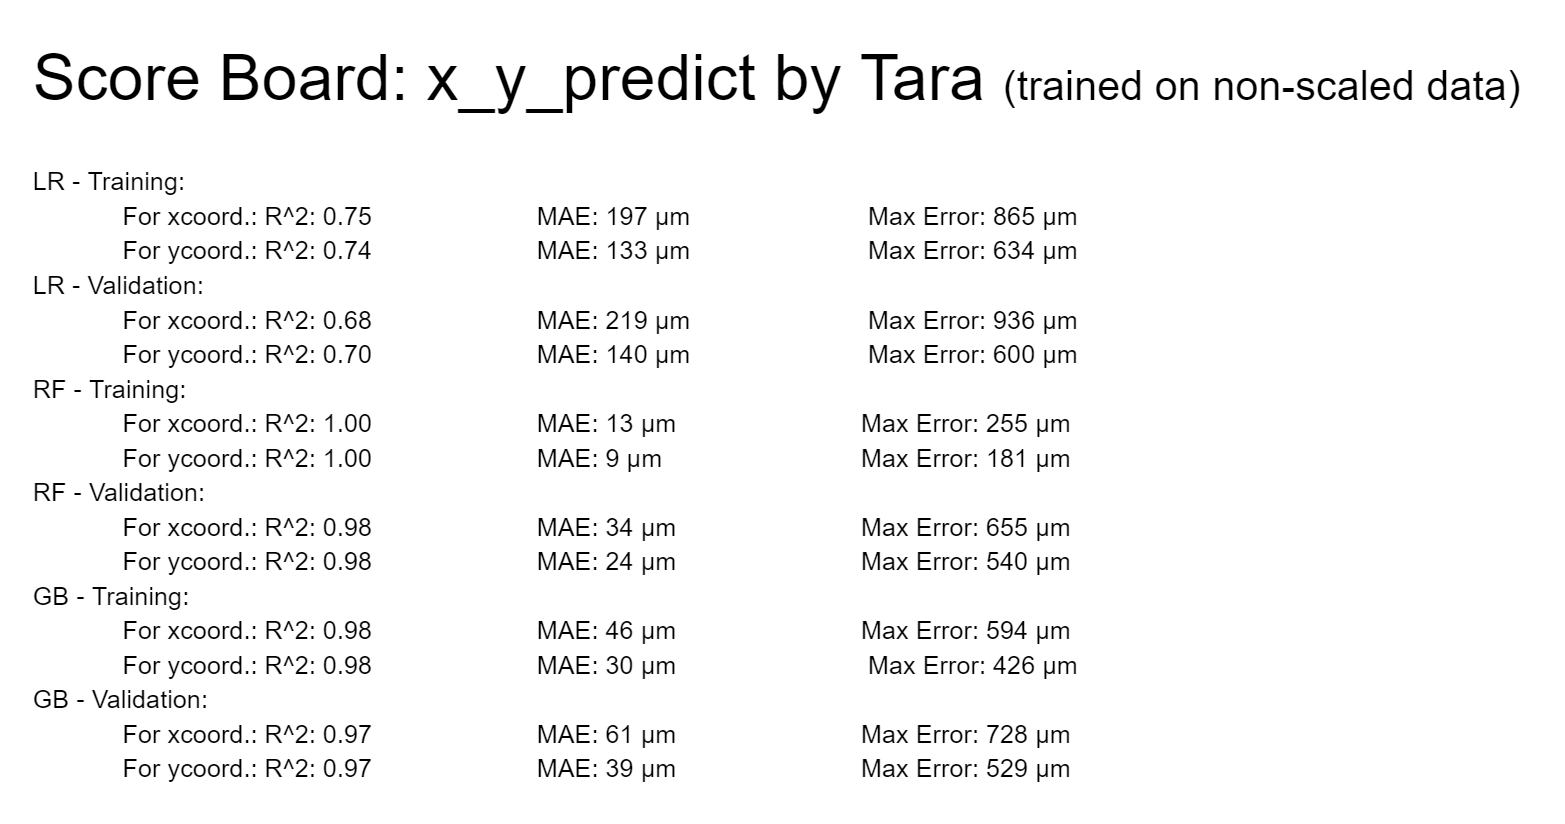

Scores for method 3 to follow. 

# Method 1

In [ ]:
# Module imports 
import argparse
import os
from os.path import join, exists
import sys
import s3fs
import yaml
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, MaxPool2D
from tensorflow.keras.models import Model, save_model
from tensorflow.keras.optimizers import Adam, SGD
%matplotlib inline

from skimage.transform import rescale, resize, downscale_local_mean

# classifiers
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [ ]:
# Limit GPU memory usage
gpus = tf.config.get_visible_devices("GPU")
for device in gpus:
    print(device)
    tf.config.experimental.set_memory_growth(device, True)

In [ ]:
# define some datset helper functions

num_particles_dict = {
    1 : '1particle',
    3 : '3particle',
    'multi': 'multiparticle'}

split_dict = {
    'train' : 'training',
    'test'   : 'test',
    'valid': 'validation'}

def dataset_name(num_particles, split, file_extension='zarr'):
    """
    Return the dataset filename given user inputs
    
    Args: 
        num_particles: (int or str) Number of particles per hologram (1, 3, or 'multi')
        split: (str) Dataset split of either 'train', 'valid', or 'test'
        file_extension: (str) Dataset file extension
    
    Returns:
        dataset: (str) Dataset name
    """
    
    valid = [1,3,'multi']
    if num_particles not in valid:
        raise ValueError("results: num_particles must be one of %r." % valid)
    num_particles = num_particles_dict[num_particles]
    
    valid = ['train','test','valid']
    if split not in valid:
        raise ValueError("results: split must be one of %r." % valid)
    split = split_dict[split]
    
    return f'synthetic_holograms_{num_particles}_{split}_small.{file_extension}'

def open_zarr(path_data, num_particles, split):
    """
    Open a HOLODEC Zarr file hosted on AWS
    
    Args: 
        path_data: (str) Path to directory containing datset
        num_particles: (int or str) Number of particles per hologram (1, 3, or 'multi')
        split: (str) Dataset split of either 'train', 'valid', or 'test'
    
    Returns:
        dataset: (xarray Dataset) Opened dataset
    """
    path_data = os.path.join(path_data, dataset_name(num_particles, split))
    fs = s3fs.S3FileSystem(anon=True, default_fill_cache=False)
    store = s3fs.S3Map(root=path_data, s3=fs, check=False)
    dataset = xr.open_zarr(store=store)
    return dataset

def scale_images(images, scaler_vals=None):
    """
    Takes in array of images and scales pixel values between 0 and 1
    
    Args: 
        images: (np array) Array of images 
        scaler_vals: (dict) Image scaler 'max' and 'min' values
        
    Returns:
        images_scaled: (np array) Scaled array of images with pixel values between 0 and 1
        scaler_vals: (dict) Image scaler 'max' and 'min' values
    """
    
    if scaler_vals is None:
        scaler_vals = {}
        scaler_vals["min"] = images.min()
        scaler_vals["max"] = images.max()
    images_scaled = (images.astype(np.float32) - scaler_vals["min"]) / (scaler_vals["max"] - scaler_vals["min"])
    return images_scaled, scaler_vals

def load_scaled_datasets(path_data, num_particles, output_cols, slice_idx,
                         split='train', scaler_vals=None):
    """
    Given a path to training or validation datset, the number of particles per
    hologram, and output columns, returns scaled inputs and raw outputs.
    
    Args: 
        path_data: (str) Path to directory containing training and validation datsets
        num_particles: (int or str) Number of particles per hologram (1, 3, or 'multi') 
        output_cols: (list of strings) List of feature columns to be used
        
    Returns:
        inputs_scaled: (np array) Input data scaled between 0 and 1
        outputs: (df) Output data specified by output_cols
        scaler_vals: (dict) list of training/validation/test files
    """
    
    if split == 'valid':
      slice_idx = int(slice_idx/3)
    print("Slicing data into inputs/outputs")
    ds = open_zarr(path_data, num_particles, split)
    inputs = ds["image"].values[:slice_idx]
    outputs = ds[output_cols].to_dataframe().loc[:slice_idx-1,:]
    ds.close()
    print(f"\t- inputs.shape: {inputs.shape}")
    print(f"\t- outputs.shape: {outputs.shape}")

    print("Scaling input data")
    if split == 'train':
      inputs_scaled, scaler_vals = scale_images(inputs)
    else:
      slice_idx = int(slice_idx/3)
      inputs_scaled, _ = scale_images(inputs, scaler_vals)
  
    inputs_scaled = np.expand_dims(inputs_scaled, -1)
    print(f"\t- inputs_scaled.shape: {inputs_scaled.shape}")

    return inputs_scaled, outputs, scaler_vals

In [ ]:
# data definitions
path_data = "ncar-aiml-data-commons/holodec/"
num_particles = 1
output_cols_one  = ["x", "y", "z", "d"]
scaler_one = MinMaxScaler()
slice_idx = 6000

In [ ]:
# load and normalize data (this takes approximately 2 minutes)
train_inputs_scaled_one,\
train_outputs_one,\
scaler_vals_one = load_scaled_datasets(path_data,
                                   num_particles,
                                   output_cols_one,
                                   slice_idx)

valid_inputs_scaled_one,\
valid_outputs_one, _ = load_scaled_datasets(path_data,
                                        num_particles,
                                        output_cols_one,
                                        slice_idx,
                                        split='valid',
                                        scaler_vals=scaler_vals_one)

# MinMaxScaler for outputs - WHY?
train_outputs_scaled_one = scaler_one.fit_transform(train_outputs_one[output_cols_one])
valid_outputs_scaled_one = scaler_one.transform(valid_outputs_one[output_cols_one])

In [ ]:
# Plot a single image (here selected the second one)
sel_image = train_inputs_scaled_one[1,:,:,0]
plt.figure()
plt.pcolormesh(range(sel_image.shape[0]), range(sel_image.shape[1]), np.transpose(sel_image))

In [ ]:
# the below few lines averages intensity values over all y-coordinates for each x-coordinate
testplot = sel_image.mean(axis=1)
plt.figure()
plt.plot(range(sel_image.shape[0]), testplot)
# this is my method of dimension reduction and hopefully what the ML models will learn during training
# we could use other functions here
# using min and max functions lose the interference pattern and the model then learns less I suspect

In [ ]:
# set up training and validation data for inputs, and x and y outputs separately
train_X_xcoord = train_inputs_scaled_one[...,0].mean(axis=2) # xcoord
train_Y_xcoord = train_outputs_scaled_one[:,0]

train_X_ycoord = train_inputs_scaled_one[...,0].mean(axis=1) # ycoord
train_Y_ycoord = train_outputs_scaled_one[:,1]

validation_X_xcoord = valid_inputs_scaled_one[...,0].mean(axis=2) # xcoord
validation_Y_xcoord = valid_outputs_scaled_one[:,0]

validation_X_ycoord = valid_inputs_scaled_one[...,0].mean(axis=1) # ycoord
validation_Y_ycoord = valid_outputs_scaled_one[:,1]

In [ ]:
# set up training and validation data for inputs, and x and y outputs separately
train_X_xcoord = train_inputs_scaled_one[...,0].mean(axis=2) # xcoord
train_Y_xcoord = train_outputs_scaled_one[:,0]

train_X_ycoord = train_inputs_scaled_one[...,0].mean(axis=1) # ycoord
train_Y_ycoord = train_outputs_scaled_one[:,1]

validation_X_xcoord = valid_inputs_scaled_one[...,0].mean(axis=2) # xcoord
validation_Y_xcoord = valid_outputs_scaled_one[:,0]

validation_X_ycoord = valid_inputs_scaled_one[...,0].mean(axis=1) # ycoord
validation_Y_ycoord = valid_outputs_scaled_one[:,1]

In [ ]:
# set up training and validation data for inputs, and x and y outputs separately
train_X_xcoord = train_inputs_scaled_one[...,0].mean(axis=2) # xcoord
train_Y_xcoord = train_outputs_scaled_one[:,0]

train_X_ycoord = train_inputs_scaled_one[...,0].mean(axis=1) # ycoord
train_Y_ycoord = train_outputs_scaled_one[:,1]

validation_X_xcoord = valid_inputs_scaled_one[...,0].mean(axis=2) # xcoord
validation_Y_xcoord = valid_outputs_scaled_one[:,0]

validation_X_ycoord = valid_inputs_scaled_one[...,0].mean(axis=1) # ycoord
validation_Y_ycoord = valid_outputs_scaled_one[:,1]

In [ ]:
%%time
# (2) RF classifiers for x and y
RFR_xcoord = RandomForestRegressor()
RFR_ycoord = RandomForestRegressor()

RFR_xcoord.fit(train_X_xcoord, train_Y_xcoord)
RFR_ycoord.fit(train_X_ycoord, train_Y_ycoord)

In [ ]:
%%time
# (2) RF classifiers for x and y
RFR_xcoord = RandomForestRegressor()
RFR_ycoord = RandomForestRegressor()

RFR_xcoord.fit(train_X_xcoord, train_Y_xcoord)
RFR_ycoord.fit(train_X_ycoord, train_Y_ycoord)

In [ ]:
# validation predictions
validation_predict_xcoord = RFR_xcoord.predict(validation_X_xcoord)
validation_predict_ycoord = RFR_ycoord.predict(validation_X_ycoord)

# validation scores
rsquare_xcoord = RFR_xcoord.score(validation_X_xcoord, validation_Y_xcoord)
rsquare_ycoord = RFR_ycoord.score(validation_X_ycoord, validation_Y_ycoord)
print(rsquare_xcoord)
print(rsquare_ycoord)

In [ ]:
# validation predictions
validation_predict_xcoord = RFR_xcoord.predict(validation_X_xcoord)
validation_predict_ycoord = RFR_ycoord.predict(validation_X_ycoord)

# validation scores
rsquare_xcoord = RFR_xcoord.score(validation_X_xcoord, validation_Y_xcoord)
rsquare_ycoord = RFR_ycoord.score(validation_X_ycoord, validation_Y_ycoord)
print(rsquare_xcoord)
print(rsquare_ycoord)

In [ ]:
# training scores
rsquare_xcoord = GBR_xcoord.score(train_X_xcoord, train_Y_xcoord)
rsquare_ycoord = GBR_ycoord.score(train_X_ycoord, train_Y_ycoord)
print(rsquare_xcoord)
print(rsquare_ycoord)

In [ ]:
# validation predictions
validation_predict_xcoord = GBR_xcoord.predict(validation_X_xcoord)
validation_predict_ycoord = GBR_ycoord.predict(validation_X_ycoord)

# validation scores
rsquare_xcoord = GBR_xcoord.score(validation_X_xcoord, validation_Y_xcoord)
rsquare_ycoord = GBR_ycoord.score(validation_X_ycoord, validation_Y_ycoord)
print(rsquare_xcoord)
print(rsquare_ycoord)

# Method 2

In [ ]:
# Downscaling by factor of 4, 8 etc.
Downscale_Factor = 4

train_inputs_scaled_one_DSIZE = np.array([downscale_local_mean(train_inputs_scaled_one[i,:,:,0], (Downscale_Factor, Downscale_Factor)) for i in range(train_inputs_scaled_one.shape[0])])
train_inputs_scaled_one_DSIZE.shape

valid_inputs_scaled_one_DSIZE = np.array([downscale_local_mean(valid_inputs_scaled_one[i,:,:,0], (Downscale_Factor, Downscale_Factor)) for i in range(valid_inputs_scaled_one.shape[0])])
train_inputs_scaled_one_DSIZE.shape

In [ ]:
# Plot a single image (here selected the second one)
sel_image = train_inputs_scaled_one[1,:,:,0]
plt.figure()
plt.pcolormesh(range(sel_image.shape[0]), range(sel_image.shape[1]), np.transpose(sel_image))

In [ ]:
testplot = sel_image[:,70]
plt.figure()
plt.plot(range(sel_image.shape[0]), testplot)

In [ ]:
# Plot a single image (here selected the second one)
sel_image = train_inputs_scaled_one_DSIZE[1,:,:]
plt.figure()
plt.pcolormesh(range(sel_image.shape[0]), range(sel_image.shape[1]), np.transpose(sel_image))

In [ ]:
testplot = sel_image[:,70]
plt.figure()
plt.plot(range(sel_image.shape[0]), testplot)

In [ ]:
# set up training and validation data for inputs to predict BOTH x and y
train_X = train_inputs_scaled_one_DSIZE.reshape(train_inputs_scaled_one_DSIZE.shape[0], train_inputs_scaled_one_DSIZE.shape[1]*train_inputs_scaled_one_DSIZE.shape[2]) 
#train_Y_xcoord = train_outputs_scaled_one[:,0] # to predict x-coord
#train_Y_ycoord = train_outputs_scaled_one[:,1] # to predict y-coord
train_Y_diamtr = train_outputs_scaled_one[:,3] # to predict diameter

validation_X = valid_inputs_scaled_one_DSIZE.reshape(valid_inputs_scaled_one_DSIZE.shape[0], valid_inputs_scaled_one_DSIZE.shape[1]*valid_inputs_scaled_one_DSIZE.shape[2])
#validation_Y_xcoord = valid_outputs_scaled_one[:,0] # to predict x-coord
#validation_Y_ycoord = valid_outputs_scaled_one[:,1] # to predict y-coord
validation_Y_diamtr = valid_outputs_scaled_one[:,3] # to predict diameter

In [ ]:
# validation predictions
#validation_predict_xcoord = lin_xcoord.predict(validation_X)
#validation_predict_ycoord = lin_ycoord.predict(validation_X)
validation_predict_diamtr = lin_diamtr.predict(validation_X)

# validation scores
#rsquare_xcoord = lin_xcoord.score(validation_X, validation_Y_xcoord)
#rsquare_ycoord = lin_ycoord.score(validation_X, validation_Y_ycoord)
rsquare_diamtr = lin_diamtr.score(validation_X, validation_Y_diamtr)
#print(rsquare_xcoord)
#print(rsquare_ycoord)
print(rsquare_diamtr)

# wildly overfit the training!

In [ ]:
%%time
# (4) Ridge classifiers for x and y
#ridge_xcoord = Ridge(alpha=10)
#ridge_ycoord = Ridge(alpha=10)
ridge_diamtr = Ridge(alpha=1)

# training
#ridge_xcoord.fit(train_X, train_Y_xcoord)
#ridge_ycoord.fit(train_X, train_Y_ycoord)
ridge_diamtr.fit(train_X, train_Y_diamtr)

# training scores
#rsquare_xcoord = ridge_xcoord.score(train_X, train_Y_xcoord)
#rsquare_ycoord = ridge_ycoord.score(train_X, train_Y_ycoord)
rsquare_diamtr = ridge_diamtr.score(train_X, train_Y_diamtr)
#print(rsquare_xcoord)
#print(rsquare_ycoord)
print(rsquare_diamtr)

In [ ]:
%%time
# (1) Linear classifiers for x and y
#lin_xcoord = LinearRegression(fit_intercept=True)
#lin_ycoord = LinearRegression(fit_intercept=True)
lin_diamtr = LinearRegression(fit_intercept=True)

# training
#lin_xcoord.fit(train_X, train_Y_xcoord)
#lin_ycoord.fit(train_X, train_Y_ycoord)
lin_diamtr.fit(train_X, train_Y_diamtr)

# training scores
#rsquare_xcoord = lin_xcoord.score(train_X, train_Y_xcoord)
#rsquare_ycoord = lin_ycoord.score(train_X, train_Y_ycoord)
rsquare_diamtr = lin_diamtr.score(train_X, train_Y_diamtr)
#print(rsquare_xcoord)
#print(rsquare_ycoord)
print(rsquare_diamtr)

In [ ]:
# validation predictions
#validation_predict_xcoord = ridge_xcoord.predict(validation_X)
#validation_predict_ycoord = ridge_ycoord.predict(validation_X)
validation_predict_diamtr = ridge_diamtr.predict(validation_X)

# validation scores
#rsquare_xcoord = ridge_xcoord.score(validation_X, validation_Y_xcoord)
#rsquare_ycoord = ridge_ycoord.score(validation_X, validation_Y_ycoord)
rsquare_diamtr = ridge_diamtr.score(validation_X, validation_Y_diamtr)
#print(rsquare_xcoord)
#print(rsquare_ycoord)
print(rsquare_diamtr)

# much better! can do grid search to find the best parameter

### Thursday 
* Evaluate two interpretation methods for your machine learning solution
* Compare interpretation of baseline with your approach
* Submit best results on project to leaderboard
* Prepare 2 Google Slides on team's approach and submit them

In [ ]:
# Thursday's code goes here


## Ultimate Submission Code
Please insert your full data processing and machine learning pipeline code in the cell below.